In [1]:
import os

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import json


def parse_sarcasm_json_dataset(file):
    for line in open(file, 'r'):
        yield json.loads(line)

In [3]:
data = list(
    parse_sarcasm_json_dataset('../../data/news_headlines_for_sarcasm_detection/Sarcasm_Headlines_Dataset_v2.json'))

df = pd.DataFrame(data)
df

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
...,...,...,...
28614,1,jews to celebrate rosh hashasha or something,https://www.theonion.com/jews-to-celebrate-ros...
28615,1,internal affairs investigator disappointed con...,https://local.theonion.com/internal-affairs-in...
28616,0,the most beautiful acceptance speech this week...,https://www.huffingtonpost.com/entry/andrew-ah...
28617,1,mars probe destroyed by orbiting spielberg-gat...,https://www.theonion.com/mars-probe-destroyed-...


In [4]:
df = df.drop(columns=['article_link'])
df

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...
...,...,...
28614,1,jews to celebrate rosh hashasha or something
28615,1,internal affairs investigator disappointed con...
28616,0,the most beautiful acceptance speech this week...
28617,1,mars probe destroyed by orbiting spielberg-gat...


In [5]:
# It is only fine-tuning, thus 400k data samples is a complete overkill. It can be reduced to 40k.

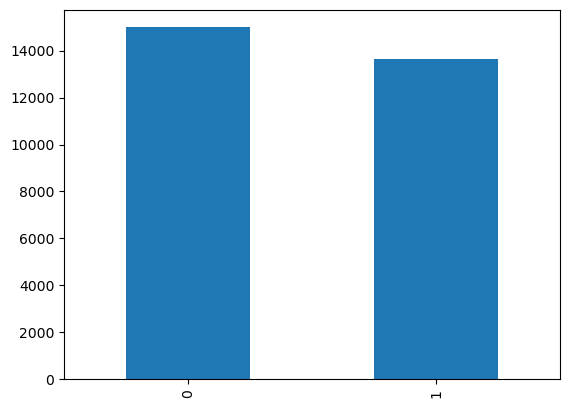

In [6]:
data = df["is_sarcastic"]
data.value_counts().plot.bar()
plt.show()

In [7]:
from datasets import Dataset

raw_dataset = Dataset.from_pandas(df)
raw_dataset

Dataset({
    features: ['is_sarcastic', 'headline'],
    num_rows: 28619
})

In [8]:
from transformers import AutoTokenizer

MAX_TOKENS = 128
EOS_TOKEN = "<|endoftext|>"
checkpoint = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(
    checkpoint,
    eos_token=EOS_TOKEN,
    pad_token=EOS_TOKEN,
    max_length=MAX_TOKENS,
    is_split_into_words=True,
)

tokenizer.padding_side = "left"

In [9]:
def tokenize_function(examples):
    examples = [ex + EOS_TOKEN for ex in examples['headline']]

    output = tokenizer(
        examples,
        add_special_tokens=True,
        max_length=MAX_TOKENS,
        truncation=True,
        padding=True,
    )

    # truncate input ids and attention mask to account for label shift
    output["input_ids"] = [x[:-1] for x in output["input_ids"]]
    output["attention_mask"] = [x[:-1] for x in output["attention_mask"]]
    return output

In [10]:
tokenized_dataset = raw_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/28619 [00:00<?, ? examples/s]

In [11]:
# Train set: 80%, Validation set: 10%, Test set: 10%
split_train_val_and_test_dataset = tokenized_dataset.train_test_split(train_size=0.8)
split_val_test_dataset = split_train_val_and_test_dataset["test"].train_test_split(test_size=0.5)

tokenized_train_dataset = split_train_val_and_test_dataset["train"]
tokenized_val_dataset = split_val_test_dataset["train"]
tokenized_test_dataset = split_val_test_dataset["test"]

In [12]:
from transformers import DataCollatorWithPadding

batch_size = 16


def convert_to_tf_dataset(hf_dataset, collator, batch_size=batch_size, shuffle=False):
    return hf_dataset.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["is_sarcastic"],
        collate_fn=collator,
        shuffle=shuffle,
        batch_size=batch_size,
    )


data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = convert_to_tf_dataset(hf_dataset=tokenized_train_dataset, collator=data_collator)
tf_val_dataset = convert_to_tf_dataset(hf_dataset=tokenized_val_dataset, collator=data_collator)
tf_test_dataset = convert_to_tf_dataset(hf_dataset=tokenized_test_dataset, collator=data_collator)

C:\Users\Karol\anaconda3\envs\ml-tf2gpu\lib\site-packages\datasets\arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [13]:
import sys

sys.path.append('../../notebooks')
from notebooks import Constants

# Callbacks
training_number = 3
model_name = "sarcasm_eng_gpt2"
training_folder = f"training_{training_number}"
checkpoint_filename = "cp-{epoch:04d}.ckpt"
training_path = os.path.join(Constants.TRAINING_CHECKPOINTS_PATH, model_name, training_folder)
checkpoint_path = os.path.join(training_path, checkpoint_filename)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True)

early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)

In [14]:
checkpoint_path

'../../training_checkpoints\\sarcasm_eng_gpt2\\training_3\\cp-{epoch:04d}.ckpt'

In [15]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam

num_epochs = 10
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

optimizer = Adam(learning_rate=lr_scheduler)

In [16]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, pad_token_id=tokenizer.pad_token_id,
                                                             eos_token_id=tokenizer.eos_token_id, use_cache=False,
                                                             num_labels=2)

All model checkpoint layers were used when initializing TFGPT2ForSequenceClassification.

Some layers of TFGPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
model.summary()

Model: "tfgp_t2for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
score (Dense)                multiple                  1536      
_________________________________________________________________
transformer (TFGPT2MainLayer multiple                  124439808 
Total params: 124,441,344
Trainable params: 124,441,344
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compile
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [19]:
history = model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=num_epochs,
                    callbacks=[checkpoint_cb, early_stop_cb])

Epoch 1/10
1431/1431 [==============================] - 192s 125ms/step - loss: 0.4703 - accuracy: 0.7688 - val_loss: 0.3567 - val_accuracy: 0.8560

Epoch 00001: saving model to ../../training_checkpoints\sarcasm_eng_gpt2\training_3\cp-0001.ckpt
Epoch 2/10
1431/1431 [==============================] - 175s 122ms/step - loss: 0.2670 - accuracy: 0.8870 - val_loss: 0.3119 - val_accuracy: 0.8823

Epoch 00002: saving model to ../../training_checkpoints\sarcasm_eng_gpt2\training_3\cp-0002.ckpt
Epoch 3/10
1431/1431 [==============================] - 174s 121ms/step - loss: 0.1814 - accuracy: 0.9264 - val_loss: 0.3005 - val_accuracy: 0.8969

Epoch 00003: saving model to ../../training_checkpoints\sarcasm_eng_gpt2\training_3\cp-0003.ckpt
Epoch 4/10
1431/1431 [==============================] - 174s 121ms/step - loss: 0.1188 - accuracy: 0.9536 - val_loss: 0.3527 - val_accuracy: 0.8931

Epoch 00004: saving model to ../../training_checkpoints\sarcasm_eng_gpt2\training_3\cp-0004.ckpt
Epoch 5/10
1431/

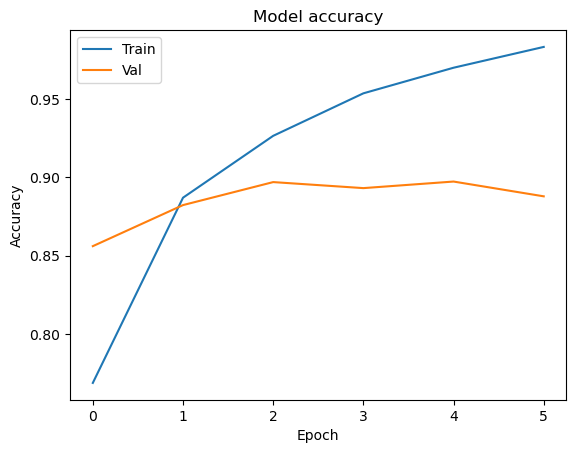

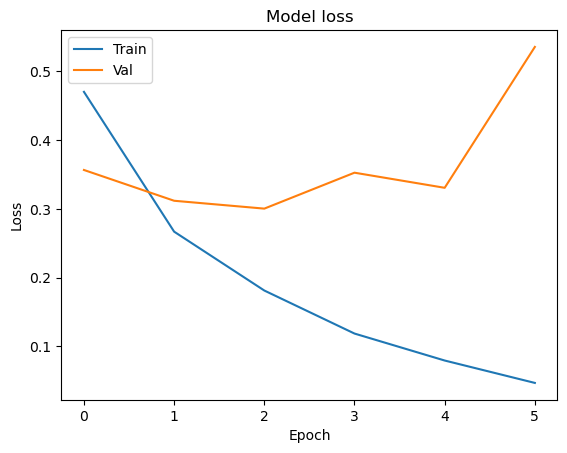

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig(f"../../documentation/models/{model_name}/figures/{training_folder}_accuracy.png")
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig(f"../../documentation/models/{model_name}/figures/{training_folder}_loss.png")
plt.show()

In [21]:
import shutil

best_model_checkpoint_index = np.argmin(history.history["val_accuracy"]) + 1
best_model_weights_path = os.path.join(training_path, checkpoint_filename.format(epoch=best_model_checkpoint_index))
best_model = model
best_model.load_weights(best_model_weights_path)

shutil.rmtree(training_path)

In [22]:
saved_model_name = f"{model_name}_{training_number}"

# Save to Saved Model format
best_model.save(os.path.join(Constants.SAVED_MODEL_LOCATION, saved_model_name, Constants.DEFAULT_MODEL_VERSION))

INFO:tensorflow:Assets written to: ../../trained_models\sarcasm_eng_gpt2_3\1\assets


INFO:tensorflow:Assets written to: ../../trained_models\sarcasm_eng_gpt2_3\1\assets


In [23]:
# Evaluation
best_model.evaluate(tf_test_dataset, batch_size=32)

179/179 [==============================] - 7s 40ms/step - loss: 0.3547 - accuracy: 0.8539


[0.35474851727485657, 0.8539482951164246]

In [24]:
# Getting predictions
prediction_logits = best_model.predict(tf_test_dataset)['logits']
probabilities = tf.nn.softmax(prediction_logits)
class_preds = np.argmax(probabilities, axis=1)

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(tokenized_test_dataset['is_sarcastic'], class_preds)
recall = recall_score(tokenized_test_dataset['is_sarcastic'], class_preds)
f1 = f1_score(tokenized_test_dataset['is_sarcastic'], class_preds)

print(f"Precision score: ", precision)
print(f"Recall score: ", recall)
print(f"F1 score: ", f1)

Precision score:  0.8977853492333902
Recall score:  0.7795857988165681
F1 score:  0.8345209817893904


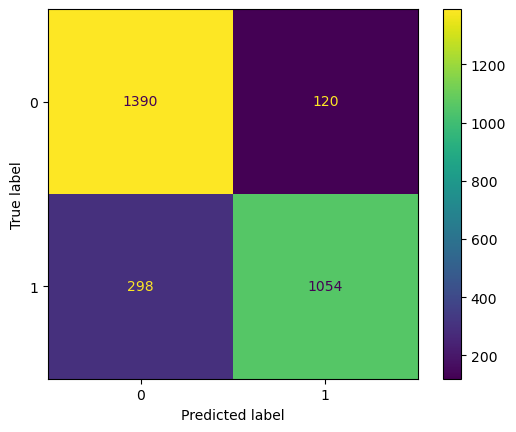

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

result = confusion_matrix(tokenized_test_dataset['is_sarcastic'], class_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=result)
disp.plot()
plt.savefig(f"../../documentation/models/{model_name}/figures/{training_folder}_confmatrix.png")
plt.show()

In [43]:
bad_prediction_count = 0
predictions_index = 0

while bad_prediction_count < 25 and predictions_index < raw_dataset.num_rows:
    predictions_index += 1

    # if bad prediction then show text and increase count
    if class_preds[predictions_index] != raw_dataset[predictions_index]['is_sarcastic']:
        print(f"""
        BAD PREDICTION:
        - INDEX: {predictions_index}
        - TEXT: {raw_dataset[predictions_index]['headline']}
        - PREDICTED VALUE: {class_preds[predictions_index]}
        - CORRECT VALUE: {raw_dataset[predictions_index]['is_sarcastic']}
        """)
        bad_prediction_count += 1


        BAD PREDICTION:
        - INDEX: 3
        - TEXT: inclement weather prevents liar from getting to work
        - PREDICTED VALUE: 0
        - CORRECT VALUE: 1
        

        BAD PREDICTION:
        - INDEX: 4
        - TEXT: mother comes pretty close to using word 'streaming' correctly
        - PREDICTED VALUE: 0
        - CORRECT VALUE: 1
        

        BAD PREDICTION:
        - INDEX: 9
        - TEXT: lots of parents know this scenario
        - PREDICTED VALUE: 1
        - CORRECT VALUE: 0
        

        BAD PREDICTION:
        - INDEX: 10
        - TEXT: this lesbian is considered a father in indiana (and an amazing one at that)
        - PREDICTED VALUE: 1
        - CORRECT VALUE: 0
        

        BAD PREDICTION:
        - INDEX: 11
        - TEXT: amanda peet told her daughter sex is 'a special hug'
        - PREDICTED VALUE: 1
        - CORRECT VALUE: 0
        

        BAD PREDICTION:
        - INDEX: 15
        - TEXT: uber ceo travis kalanick stepping